## 比較的うまくいく例
T2Iで生成し、同じモデル・似たプロンプトでI2Vを行う

In [34]:
# create base image
import torch
from diffusers import MotionAdapter, StableDiffusionPipeline, DDIMScheduler
from diffusers.utils import export_to_gif, load_image, export_to_video
from pipeline_animatediff_img2video import AnimateDiffImgToVideoPipeline
import os

model_id = "sinkinai/anime-pastel-dream-soft-baked-vae"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

output = pipe(
    prompt="a girl is looking at flowers on a hill, yellow flower field, 1girl, solo, upper body, blue sky, cliff above the sea, best quality",
    negative_prompt="bad quality, worse quality",
    num_inference_steps=50,
    generator=torch.Generator().manual_seed(42),
)

base_image_path="generated/10_i2v_anime_base.png"
os.makedirs(os.path.dirname(base_image_path), exist_ok=True)
output.images[0].save(base_image_path)

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

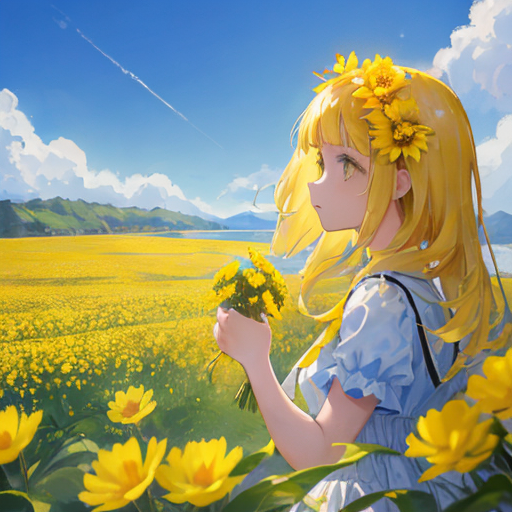

In [35]:
from IPython.display import Image

Image(base_image_path)

In [36]:
# create animation
model_id = "sinkinai/anime-pastel-dream-soft-baked-vae"
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2")
pipe = AnimateDiffImgToVideoPipeline.from_pretrained(model_id, motion_adapter=adapter)
pipe.scheduler = DDIMScheduler.from_pretrained(
    model_id, 
    subfolder="scheduler", 
    clip_sample=False, 
    timestep_spacing="linspace", 
    beta_schedule="linear", 
    steps_offset=1)

# enable memory savings
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()

image = load_image(base_image_path).resize((512, 512))
output = pipe(
    prompt="a girl is collecting flowers on a hill, yellow flower field, 1girl, solo, upper body, blue sky, cliff above the sea, best quality", # collectingのほうが動きが出る
    negative_prompt="bad quality, worse quality",
    num_frames=16,
    image=image,
    guidance_scale=4.0,
    num_inference_steps=25,
    strength=0.9,
    latent_interpolation_method="slerp",
    generator=torch.Generator("cpu").manual_seed(42),
)
frames = output.frames[0]

output_path = "generated/10_i2v_anime_1"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'only_cross_attention': False, 'attention_head_dim': 8, 'dual_cross_attention': False, 'class_embed_type': None, 'num_class_embeds': None, 'upcast_attention': False, 'resnet_time_scale_shift': 'default', 'time_embedding_type': 'positional', 'timestep_post_act': None, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'class_embeddings_concat': False} were passed to UNetMotionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/25 [00:00<?, ?it/s]

'generated/10_i2v_anime_1.gif'

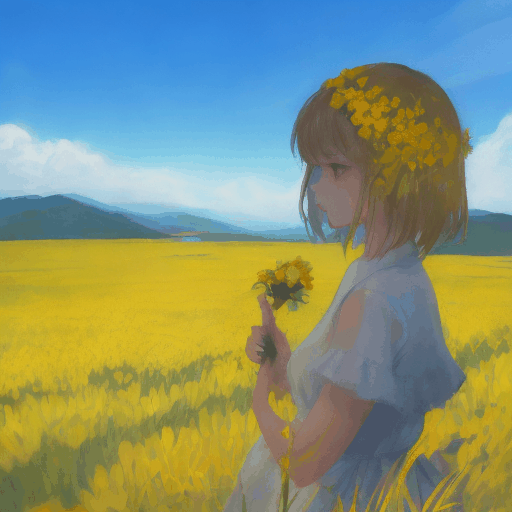

In [38]:
Image(output_path+".gif")

## うまくいかない例
元のモデルからかけ離れた画像を使う（例：DALLE-3生成画像）

In [39]:
image = load_image("school_girl.png").resize((512, 512))
output = pipe(
    prompt="a girl is dancing, 1girl, solo, best quality",
    negative_prompt="bad quality, worse quality",
    num_frames=16,
    image=image,
    guidance_scale=3,
    num_inference_steps=25,
    strength=0.9,
    latent_interpolation_method="slerp",
    generator=torch.Generator("cpu").manual_seed(42),
)
frames = output.frames[0]

output_path = "generated/10_i2v_anime_2"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

  0%|          | 0/25 [00:00<?, ?it/s]

'generated/10_i2v_anime_2.gif'

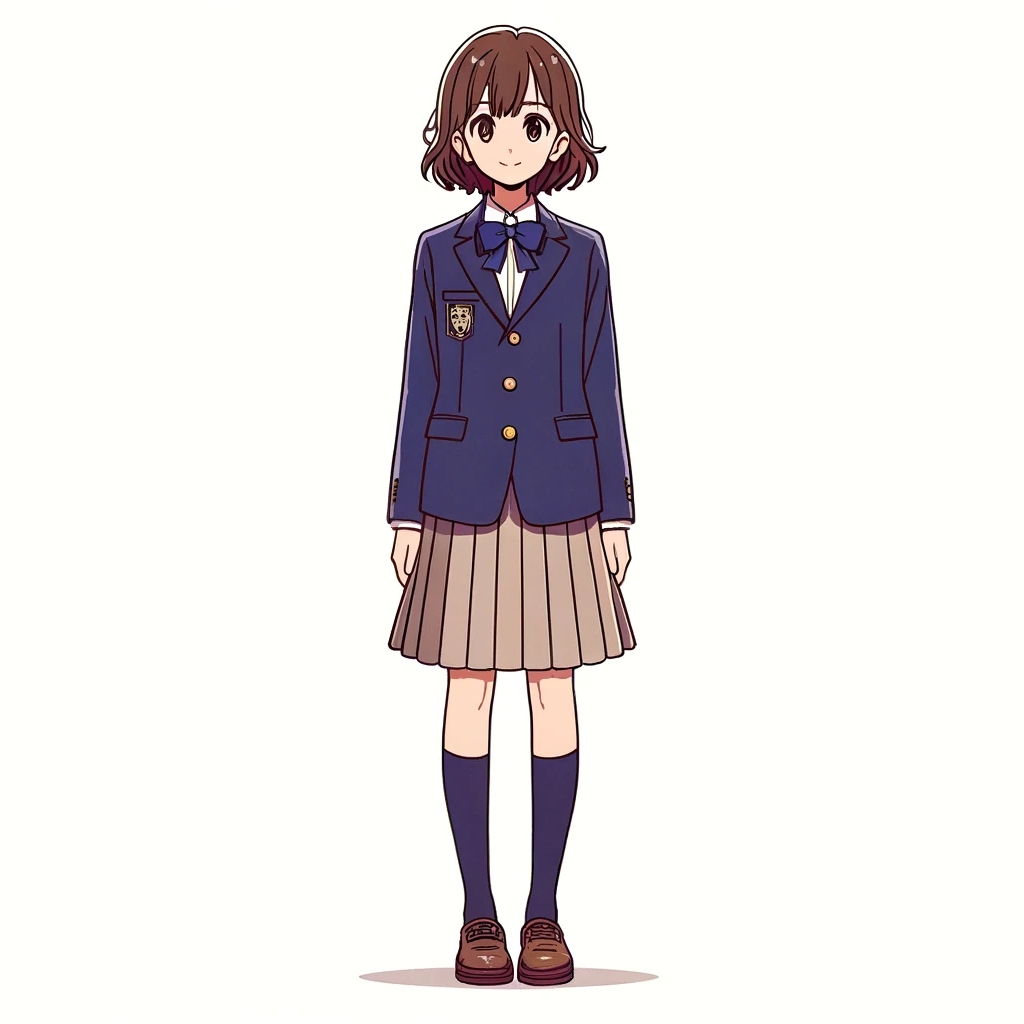

In [40]:
Image("school_girl.png", width=512)

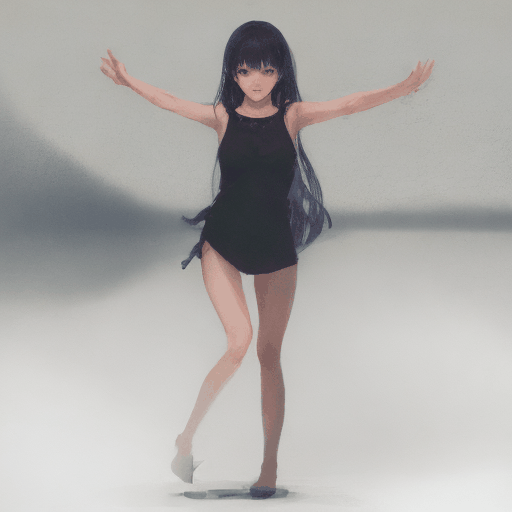

In [41]:
Image(output_path+".gif")

In [ ]:
# 21.7GB